In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor

#df_13 = pd.read_csv('13_clean.csv')
#df_13.head()

years = ['85', '87', '89', '91', '93', '95', '97', '99', '01', '03', '05', '07', '09', '11', '13']
years_num = [1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013 ]

df_allYears = pd.DataFrame()
for year, i in zip(years, years_num):
    df = pd.read_csv(year + '_clean.csv')
    df['YEAR'] = i
    df_allYears = df_allYears.append(df)
    
#choose columns that are independent, e.g. COSTMED, COSTMEDRELAMITPCT, FMTCOSTMEDRELAMIPCT 
#show the same data in different format; ditto for FMTINCRELAMICAT and INCRELAMIPCT
# drop CONTROL as well
cols = ['CONTROL', 'COSTMED', 'FMTCOSTMEDRELAMICAT', 'FMTINCRELAMICAT']
df_toKeep = df_allYears.drop(cols, axis=1)
print(df_toKeep.shape)

#removing columns related to cost since these are related to target variable ZSMHC (monthly housing cost)
cols = ['COSTMEDRELAMIPCT', 'BURDEN', 'OTHERCOST', 'UTILITY']
df_toKeep = df_toKeep.drop(cols, axis=1)
print(df_toKeep.shape)

df_toKeep = df_toKeep.dropna()
print(df_toKeep.shape)

#remove values of FMTMETRO set to 9;
df_toKeep = df_toKeep.loc[~df_toKeep['FMTMETRO'].str.contains('9', regex=False)]


#drop FMTSTATUS - earlier generated ill-defined matrix warning for ridge regression;
#values for this column is constanct for several years
df_toKeep = df_toKeep.drop('FMTSTATUS', axis=1)

#converting REGION from int type to string type
df_toKeep['REGION'] = df_toKeep['REGION'].apply(str)

#convert categorical variables to indicator variables
df_toKeep = pd.get_dummies(df_toKeep, drop_first=True)

print(df_toKeep.columns)

(771870, 33)
(771870, 29)
(486785, 29)
Index(['AGE', 'BEDRMS', 'FMR', 'INCRELAMIPCT', 'IPOV', 'LMED', 'NUNITS', 'PER',
       'ROOMS', 'TOTSAL', 'VALUE', 'ZINC2', 'ZSMHC', 'ABL50', 'ABL80',
       'ABLMED', 'GL50', 'GL80', 'GLMED', 'L50', 'YEAR',
       'FMTBUILT_'1960-1979'', 'FMTBUILT_'1980-1989'', 'FMTBUILT_'1990-1999'',
       'FMTBUILT_'2000-2009'', 'FMTBUILT_'After 2010'',
       'FMTBUILT_'not_defined'', 'FMTASSISTED_'0 Not Assisted'',
       'FMTSTRUCTURETYPE_'2 2-4 units'', 'FMTSTRUCTURETYPE_'3 5-19 units'',
       'FMTSTRUCTURETYPE_'4 20-49 units'', 'FMTSTRUCTURETYPE_'5 50+ units'',
       'FMTSTRUCTURETYPE_'6 Mobile Home'', 'REGION_2.0', 'REGION_3.0',
       'REGION_4.0', 'FMTMETRO_'Central City'',
       'FMTZADEQ_'2 Moderately Inadequ'', 'FMTZADEQ_'3 Severely Indadequa''],
      dtype='object')


In [2]:
years = [1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013]

quantiles = {}
for year in years:
    quantiles[year] = df.loc[df['YEAR'] == year, 'ZSMHC'].quantile(0.9)
    
df_toKeep['QUANTILE'] = df_toKeep['YEAR']
df_toKeep.replace({'QUANTILE':quantiles})

df_toKeep['IS_TOP_10'] = df_toKeep['ZSMHC'] >= df_toKeep['QUANTILE']

df_toKeep['IS_TOP_10'] = df_toKeep['IS_TOP_10'].apply(int)

df_toKeep = df_toKeep.drop(['QUANTILE', 'ZSMHC'], axis=1)

In [3]:
X = df_toKeep.drop(['IS_TOP_10'], axis=1).values

y = df_toKeep['IS_TOP_10'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_scaled = scale(X_train)
#y_train_scaled = scale(y_train)

X_test_scaled = scale(X_test)
#y_test_scaled = scale(y_test)

from sklearn import svm

clf = svm.SVC(random_state=42)
clf.fit(X_train_scaled, y_train)

score = clf.score(X_test_scaled, y_test)

print('score = ', score)

score =  0.9257732383062497


In [4]:
from sklearn import metrics

y_pred = clf.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.9257732383062497
Precision: 0.7453714285714286
Recall: 0.4314918954680781


In [5]:
metrics.confusion_matrix(y_test,y_pred)

array([[128440,   2228],
       [  8593,   6522]])

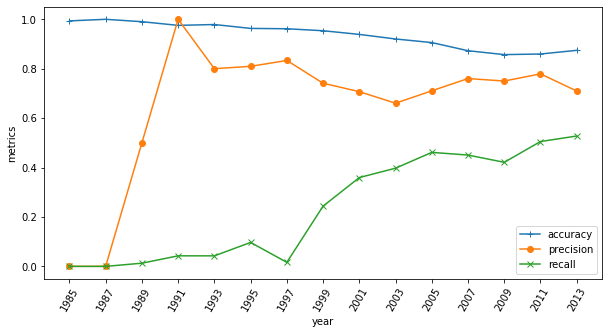

In [36]:
cols = list(df_toKeep.drop(['IS_TOP_10'], axis=1).columns)
year_array = X_test[:,cols.index('YEAR')]

accuracies = []
precisions = []
recalls = []

#accuracy is sum of true positive and true negatives divide by total number of observations
#precision is true positive divided by total predicted positive values
#recall is true positive divided by total actual positive values

for year in years:
    y_test_year = y_test[year_array == year]
    y_pred_year = y_pred[year_array == year]
    #print(np.sum(year_array == year))
    accuracies.append(metrics.accuracy_score(y_test_year, y_pred_year))
    precisions.append(metrics.precision_score(y_test_year, y_pred_year))
    recalls.append(metrics.recall_score(y_test_year, y_pred_year))

plt.figure(figsize=(10,5))
plt.plot(years, accuracies, label='accuracy', marker = '+')
plt.plot(years, precisions, label='precision', marker = 'o')
plt.plot(years, recalls, label='recall', marker = 'x')
plt.xticks(years, years, rotation=60)
plt.xlabel('year')
plt.ylabel('metrics')
plt.legend()
plt.show()

In [37]:
for year in [1985, 1987]:
    y_test_year = y_test[year_array == year]
    y_pred_year = y_pred[year_array == year]
    print(metrics.confusion_matrix(y_test_year, y_pred_year))    

[[7550    0]
 [  50    0]]
[[7993    0]
 [   1    0]]


Because the second column of confusion matrix consists of zeroes, the model does not predict any positive values for years 1985 and 1987. Therfore the precision is undefined and set to zero in the plot above.